In [1]:
from __future__ import unicode_literals
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from helper_funcs import * 
from torchvision.models import *
from torchvision.models.resnet import BasicBlock

import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models

from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.optim as optim

from numpy import linalg as LA

batch_size=128
random_state = 42 
learning_rate = 1e-3


# https://www.kaggle.com/tonysun94/pytorch-1-0-1-on-mnist-acc-99-8

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
def print_accuracy(testloader, net):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels, _ = data
            outputs = net(images.to(device))
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels.to(device)).sum().item()

    print('Accuracy of the network on test images: %d %%' % (
        100 * correct / total))

In [ ]:
def get_class_accuracies(net):
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    with torch.no_grad():
        for data in testloader:
            images, labels, _ = data
            outputs = net(images.to(device))
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels.to(device)).squeeze()
            for i in range(4):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1


    for i in range(10):
        print('Accuracy of %5s : %2d %%' % (
            classes[i], 100 * class_correct[i] / class_total[i]))

In [ ]:
def show_errors(testloader, net, n=10):
    count = 0
    ims = []
    preds = []
    actual = []
    with torch.no_grad():
        for data in testloader:
            images, labels, _ = data
            outputs = net(images.to(device))
            _, predicted = torch.max(outputs.data, 1)            
            
            for (im, pred, label) in zip(images, predicted, labels):
                if pred.numpy() != label.numpy():
                    count += 1
                    ims.append(im.numpy())
                    preds.append(pred)
                    actual.append(label)
                    
                if count >= n: 
                    return ims, preds, actual 
                
    plot_gallery2(ims, preds, 2, 5)

In [3]:
transform=transforms.Compose([
    transforms.Resize(28),
    transforms.ToTensor(),
])

trainset = BengaliDataset("data/train.csv","data/trainsplit", transform)
testset = BengaliDataset("data/test.csv","data/testsplit", transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                         shuffle=True, num_workers=0)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=True, num_workers=0)

df = pd.read_csv("data/train.csv")
classes = list(range(df.label.max()+1))
n_classes = len(classes)

In [4]:
images, labels,t = next(iter(trainloader))
# images, labels,t = next(iter(testloader))

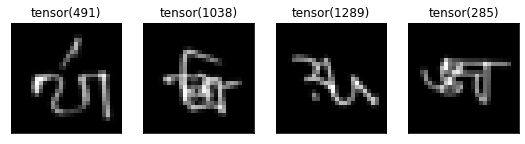

In [5]:
# show images
plot_gallery2(images,labels,1,4)

In [6]:
df.label.max()+1

1292

In [9]:
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models.resnet import ResNet, BasicBlock, Bottleneck


class MNISTResNet(ResNet):
    def __init__(self):
        super(MNISTResNet, self).__init__(BasicBlock, [2, 2, 2, 2], num_classes=n_classes) # Based on ResNet18
        # super(MNISTResNet, self).__init__(BasicBlock, [3, 4, 6, 3], num_classes=10) # Based on ResNet34
        # super(MNISTResNet, self).__init__(Bottleneck, [3, 4, 6, 3], num_classes=10) # Based on ResNet50
        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=1, padding=3,bias=False)

model = MNISTResNet()
# print(model)

In [10]:
def train(train_loader, model, criterion, optimizer, epoch):
    model.train()

    for batch_idx, (data, target, _) in enumerate(train_loader):
        # if GPU available, move data and target to GPU
        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()
        
        # compute output and loss
        output = model(data)
        loss = criterion(output, target)
        
        # TODO:
        # 1. add batch metric (acc1, acc5)
        # 2. add average metric top1=sum(acc1)/batch_idx, top5 = sum(acc5)/batch_idx
        
        # backward and update model
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (batch_idx + 1)% 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, (batch_idx + 1) * len(data), len(train_loader.dataset),
                100. * (batch_idx + 1) / len(train_loader), loss.data.item()))

In [11]:
def validate(val_loader, model, criterion):
    model.eval()
    loss = 0
    correct = 0
    
    for _, (data, target, _) in enumerate(val_loader):
        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()
        
        output = model(data)
        
        loss += criterion(output, target).data.item()

        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()
        
    loss /= len(val_loader.dataset)
        
    print('\nOn Val set Average loss: {:.4f}, Accuracy: {}/{} ({:.3f}%)\n'.format(
        loss, correct, len(val_loader.dataset),
        100.0 * float(correct) / len(val_loader.dataset)))

In [12]:
# example config, use the comments to get higher accuracy
total_epoches = 20 # 50
step_size = 5     # 10
base_lr = 0.01    # 0.01

optimizer = optim.Adam(model.parameters(), lr=base_lr)
criterion = nn.CrossEntropyLoss()
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=0.1)

if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()

In [13]:
track_loss = []
track_accuracy = []
for epoch in range(total_epoches):
    train(train_loader=trainloader, model=model, criterion=criterion, optimizer=optimizer, epoch=epoch)
    validate(val_loader=testloader, model=model, criterion=criterion)
    exp_lr_scheduler.step()

Train Epoch: 0 [12800/134562 (10%)]	Loss: 7.160809
Train Epoch: 0 [25600/134562 (19%)]	Loss: 7.124442
Train Epoch: 0 [38400/134562 (29%)]	Loss: 7.104523
Train Epoch: 0 [51200/134562 (38%)]	Loss: 6.534368
Train Epoch: 0 [64000/134562 (48%)]	Loss: 5.878928
Train Epoch: 0 [76800/134562 (57%)]	Loss: 5.044273
Train Epoch: 0 [89600/134562 (67%)]	Loss: 4.610102
Train Epoch: 0 [102400/134562 (76%)]	Loss: 4.164382
Train Epoch: 0 [115200/134562 (86%)]	Loss: 3.647674
Train Epoch: 0 [128000/134562 (95%)]	Loss: 3.074728

On Val set Average loss: 0.0235, Accuracy: 16640/66278 (25.106%)

Train Epoch: 1 [12800/134562 (10%)]	Loss: 2.495641
Train Epoch: 1 [25600/134562 (19%)]	Loss: 2.446294
Train Epoch: 1 [38400/134562 (29%)]	Loss: 2.355180
Train Epoch: 1 [51200/134562 (38%)]	Loss: 1.778749
Train Epoch: 1 [64000/134562 (48%)]	Loss: 1.888546
Train Epoch: 1 [76800/134562 (57%)]	Loss: 1.928643
Train Epoch: 1 [89600/134562 (67%)]	Loss: 1.579633
Train Epoch: 1 [102400/134562 (76%)]	Loss: 1.750373
Train Epoch

Train Epoch: 14 [25600/134562 (19%)]	Loss: 0.027882
Train Epoch: 14 [38400/134562 (29%)]	Loss: 0.119454
Train Epoch: 14 [51200/134562 (38%)]	Loss: 0.059149
Train Epoch: 14 [64000/134562 (48%)]	Loss: 0.047948
Train Epoch: 14 [76800/134562 (57%)]	Loss: 0.053731
Train Epoch: 14 [89600/134562 (67%)]	Loss: 0.030544
Train Epoch: 14 [102400/134562 (76%)]	Loss: 0.026482
Train Epoch: 14 [115200/134562 (86%)]	Loss: 0.055737
Train Epoch: 14 [128000/134562 (95%)]	Loss: 0.093401

On Val set Average loss: 0.0052, Accuracy: 56839/66278 (85.758%)

Train Epoch: 15 [12800/134562 (10%)]	Loss: 0.106048
Train Epoch: 15 [25600/134562 (19%)]	Loss: 0.057924
Train Epoch: 15 [38400/134562 (29%)]	Loss: 0.046166
Train Epoch: 15 [51200/134562 (38%)]	Loss: 0.037320
Train Epoch: 15 [64000/134562 (48%)]	Loss: 0.071592
Train Epoch: 15 [76800/134562 (57%)]	Loss: 0.062932
Train Epoch: 15 [89600/134562 (67%)]	Loss: 0.019784
Train Epoch: 15 [102400/134562 (76%)]	Loss: 0.055702
Train Epoch: 15 [115200/134562 (86%)]	Loss: 0